In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import gym
from collections import deque
import random
import itertools
from torch import nn
from torch.nn import functional
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

import pickle

def save_rewards_data(rewards_data, filename='rewards_data.pkl'):
    """Save the rewards data to a pickle file."""
    with open(filename, 'wb') as file:
        pickle.dump(rewards_data, file)
    print(f'Rewards data saved to {filename}')


def load_rewards_data(filename='rewards_data.pkl'):
    """Load the rewards data from a pickle file."""
    try:
        with open(filename, 'rb') as file:
            rewards_data = pickle.load(file)
        print(f'Rewards data loaded from {filename}')
        return rewards_data
    except FileNotFoundError:
        print(f'Error: The file {filename} does not exist. Please check the file path and try again.')
        return None
    except Exception as e:
        print(f'An error occurred while loading the data: {e}')
        return None

class tilecoding:
  def __init__(self, env, num_tile, bins):
    self.env = env
    self.obs_dim = env.observation_space.shape[0]
    self.bins = bins
    self.num_tile = num_tile
    self.numTiles = (self.bins**self.obs_dim) * self.num_tile


  def tiles_grid(self, offset_pos):
    min_pos, min_vel, min_angle, min_v_angle = self.env.observation_space.low
    max_pos, max_vel, max_angle, max_v_angle = self.env.observation_space.high
    bins = self.bins

    pos_grid =  np.linspace(min_pos, max_pos, bins )[1:-1] +  offset_pos[0]#np.concatenate((np.array([min_pos]), np.linspace(-2, 2, bins)[0:-1], np.array([max_pos])))
    angle_grid = np.linspace(min_angle, max_angle, bins )[1:-1] + + offset_pos[2] #np.concatenate((np.array([min_angle]), np.linspace(-0.3, 0.3, bins)[0:-1], np.array([max_angle])))
    vel_grid = np.concatenate((np.array([min_vel]), np.linspace(-5, 5, bins)[2:-2], np.array([max_vel])))+ offset_pos[1]
    angle_vel_grid = np.concatenate((np.array([-9999]), np.linspace(-5, 5, bins)[2:-2], np.array([9999]))) + + offset_pos[3]
    grid = [pos_grid, vel_grid, angle_grid, angle_vel_grid ]
    return grid #np.array(grid).flatten()
  
  def create_tilings(self):
    high = np.array([2.5, 5, 0.42, 5])
    low = np.array([-2.5, -5, -0.42, -5])
    offset_pos = (high - low)/(self.num_tile*self.bins)
    n = self.num_tile // 2
    num = -n*offset_pos
    #print(num)
    tiling_specs = [-n*offset_pos]
    for i in range(self.num_tile - 1):
      num += offset_pos
      #print(num)
      tiling_specs.append(num)

    
    #tiling_specs = [-offset_pos, tuple([0.0]*self.env.observation_space.shape[0]), offset_pos]
    #print([print(offsets) for offsets in tiling_specs])
    return [self.tiles_grid(offsets) for offsets in tiling_specs]

  def discretize(self, obs, tile_grid):
    encode = []
    for grids in tile_grid:
      #tile_grid = np.array(tile_grid).reshape(self.obs_dim, -1)
      position_tuple = tuple(int(np.digitize(state, grid)) for state, grid in zip(obs, grids))
      #print(position_tuple)
      array = []
      for i in range(self.obs_dim):
        state = [0]*self.bins
        state[position_tuple[i] - 1] = 1
        array.append(state)
      encode.append(array)
    return np.array(encode).flatten()


cpu


In [2]:
class Model(nn.Module):
    def __init__(self, input_features, output_values):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(in_features=input_features, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=32)
        self.fc3 = nn.Linear(in_features=32, out_features=output_values)

    def forward(self, x):
        x = functional.selu(self.fc1(x))
        x = functional.selu(self.fc2(x))
        x = self.fc3(x)
        return x

class DDQN:
    def __init__(self, env, bins, num_tiles, discretizer, use_cuda=True, learning_rate=1e-5, gamma=0.7, memory_len=10000, start_epsilon=1):
        self.device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")
        self.env = env
        self.discretizer = discretizer
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.tile_grids = self.discretizer.create_tilings()

        self.epsilon = start_epsilon
        self.min_epsilon = 0.001
        self.epsilon_decay = 0.9 / 2.5e3
        self.memory_len = memory_len
        self.memory = deque(maxlen=self.memory_len)
        self.criterion = nn.MSELoss()

        input_features = env.observation_space.shape[0]*bins*num_tiles
        output_values = env.action_space.n
        self.policy_net = Model(input_features, output_values).to(self.device)
        self.target_net = Model(input_features, output_values).to(self.device)

        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

    def get_states_tensor(self, sample, states_idx):
        sample_len = len(sample)
        states_tensor = torch.empty((sample_len, self.n_features), dtype=torch.float32, requires_grad=False)

        features_range = range(self.n_features)
        for i in range(sample_len):
            for j in features_range:
                states_tensor[i, j] = sample[i][states_idx][j].item()

        return states_tensor

    def normalize_state(self, state):
        if type(state) == tuple:
            state = state[0]
        state[0] /= 2.5
        state[1] /= 2.5
        state[2] /= 0.3
        state[3] /= 0.3

    def state_reward(self, state, env_reward):
        return env_reward - (abs(state[0]) + abs(state[2])) / 2.5

    def get_action(self, state, e=0.001):
        if random.random() < e:
            return random.randrange(0, self.env.action_space.n)
        else:
            encoded_state = self.discretizer.discretize(state, self.tile_grids)
            encoded_state = torch.tensor(encoded_state, dtype=torch.float32, device=self.device)
            return self.policy_net(encoded_state).argmax().item()

    def fit(self, model, inputs, labels):
        inputs = inputs.to(self.device)
        labels = labels.to(self.device)
        train_ds = TensorDataset(inputs, labels)
        train_dl = DataLoader(train_ds, batch_size=5)

        optimizer = torch.optim.Adam(params=model.parameters(), lr=self.learning_rate)
        model.train()
        total_loss = 0.0

        for x, y in train_dl:
            out = model(x)
            loss = self.criterion(out, y)
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        return total_loss / len(train_dl)

    def optimize_model(self, train_batch_size=100):
        if len(self.memory) < train_batch_size:
            return
        train_sample = random.sample(self.memory, train_batch_size)

        state = torch.tensor([s[0] for s in train_sample], dtype=torch.float32, device=device)
        next_state = torch.tensor([s[3] for s in train_sample], dtype=torch.float32, device=device)

        q_estimates = self.policy_net(state).detach()
        next_state_q_estimates = self.target_net(next_state).detach()
        next_actions = self.policy_net(next_state).argmax(dim=1)

        for i in range(len(train_sample)):
            next_action = next_actions[i].item()
            q_estimates[i][train_sample[i][1]] = (self.state_reward(next_state[i], train_sample[i][2]) +
                                                  self.gamma * next_state_q_estimates[i][next_action].item())

        self.fit(self.policy_net, state, q_estimates)

    def train_one_episode(self):
        current_state = self.env.reset()
        #self.normalize_state(current_state)
        done = False
        score = 0
        reward = 0
        step = 0
        while not done and step < 500:
            if type(current_state) == tuple:
                current_state = current_state[0]
            action = self.get_action(current_state, self.epsilon)
            next_state, env_reward, done,  _ = self.env.step(action)
            #self.normalize_state(next_state)
            encoded_current_state = self.discretizer.discretize(current_state, self.tile_grids)
            encoded_next_state = self.discretizer.discretize(next_state, self.tile_grids)
            self.memory.append((encoded_current_state, action, env_reward, encoded_next_state))
            current_state = next_state
            score += env_reward
            reward += self.state_reward(next_state, env_reward)

            self.optimize_model(100)
            step += 1

            self.epsilon = max(self.min_epsilon, self.epsilon - self.epsilon_decay)

        return score, reward

    def test(self):
        state = self.env.reset()
        #self.normalize_state(state)
        done = False
        score = 0
        reward = 0
        step = 0
        while not done and step < 500:
            if len(state) != 4:
                state = state[0]
            action = self.get_action(state, 0)  # Using 0 to bypass random action selection
            state, env_reward, done,   _ = self.env.step(action)
            #self.normalize_state(state)
            score += env_reward
            reward += self.state_reward(state, env_reward)
            step += 1

        return score, reward

In [3]:
env = gym.make('CartPole-v1')

bins = 15
num_tiles = 2
TC = tilecoding(env, num_tiles, bins)

In [4]:
def main(used_alpha, used_epsilon, env, bins, num_tiles, discretizer, target_update_delay, test_delay, memory_len=10000, num_runs=1, num_episode=1000, save_file=""):


    # Initialize storage for reward data
    rewards_data = {epsilon: {alpha: [] for alpha in used_alpha} for epsilon in used_epsilon}

    for epsilon in used_epsilon:
        for alpha in used_alpha:
            print(f"Training with epsilon: {epsilon}, alpha: {alpha}")
            run_rewards = []  # Collect rewards for each run for the current config

            for run in range(num_runs):
                
                # avoid decay
                current_epsilon = epsilon

                print(f"Run {run + 1}/{num_runs}")
                
                # renew the wrapper class
                ddqn = DDQN(
                    env=env, 
                    bins = bins, 
                    num_tiles = num_tiles,
                    discretizer=discretizer, 
                    use_cuda=True, 
                    learning_rate=alpha, 
                    gamma=0.99,
                    memory_len=memory_len, 
                    start_epsilon=current_epsilon
                )

                best_test_reward = 0

                episode_rewards = []  # Collect rewards for each episode in the current run
                for i in range(num_episode):
                    score, reward = ddqn.train_one_episode()

                    print(f'Episode {i + 1}: score: {score} - reward: {reward}')

                    if i % target_update_delay == 0:
                        ddqn.target_net.load_state_dict(ddqn.policy_net.state_dict())
                        ddqn.target_net.eval()

                    if (i + 1) % test_delay == 0:
                        test_score, test_reward = ddqn.test()
                        print(f'Test Episode {i + 1}: test score: {test_score} - test reward: {test_reward}')
                        if test_reward > best_test_reward:
                            print('New best test reward. Saving model')
                            best_test_reward = test_reward
                            # torch.save(ddqn.policy_net.state_dict(), f'policy_net_{run}.pth')

                    # Add the rewards
                    episode_rewards.append(score)

                if num_episode % test_delay != 0:
                    test_score, test_reward = ddqn.test()
                    print(f'Test Episode {num_episode}: test score: {test_score} - test reward: {test_reward}')
                    if test_reward > best_test_reward:
                        print('New best test reward. Saving model')
                        best_test_reward = test_reward
                        # torch.save(ddqn.policy_net.state_dict(), f'policy_net_{run}.pth')

                # save the run rewards
                run_rewards.append(episode_rewards)

                print(f'best test reward: {best_test_reward}')

            # Store the rewards for the current epsilon and alpha configuration
            rewards_data[epsilon][alpha] = run_rewards

    if not(save_file == ""):
        save_rewards_data(rewards_data, save_file)

    return rewards_data

In [23]:
rewards_data = main(
    used_alpha=[1e-4, 1e-5], 
    used_epsilon=[0.1, 0.01],  # start epsilon
    env=env, 
    bins = bins,
    num_tiles= num_tiles,
    discretizer=TC,
    target_update_delay=2, 
    test_delay=10,
    memory_len=10000, 
    num_runs=10, 
    num_episode=500, 
    save_file="DDQN_TC_CP_2.pkl"
)

Training with epsilon: 0.1, alpha: 0.0001
Run 1/10
Episode 1: score: 11.0 - reward: 10.339026134984469
Episode 2: score: 10.0 - reward: 9.331988793746078
Episode 3: score: 9.0 - reward: 8.479570232383614
Episode 4: score: 9.0 - reward: 8.493747570775845
Episode 5: score: 10.0 - reward: 9.347085674850188
Episode 6: score: 10.0 - reward: 9.349230344169113
Episode 7: score: 9.0 - reward: 8.58018207501362
Episode 8: score: 11.0 - reward: 10.163865163022484
Episode 9: score: 11.0 - reward: 10.366161773809552
Episode 10: score: 11.0 - reward: 10.346225495597823
Test Episode 10: test score: 10.0 - test reward: 9.39039360179129
New best test reward. Saving model
Episode 11: score: 10.0 - reward: 9.472656246845945
Episode 12: score: 10.0 - reward: 9.378716834418364
Episode 13: score: 9.0 - reward: 8.313238359621245
Episode 14: score: 10.0 - reward: 9.422970929004602
Episode 15: score: 9.0 - reward: 8.32588471403096
Episode 16: score: 8.0 - reward: 7.491655751775537
Episode 17: score: 9.0 - rewa

In [21]:
import matplotlib.pyplot as plt

def plot_rewards(rewards_data, algorithm_name="Q learning"):
    """Plot the average performance and IQR of the policy."""
    plt.figure(figsize=(14, 7))

    for epsilon, alphas in rewards_data.items():
        for alpha, data in alphas.items():
            # Calculate average and IQR across runs for each episode
            data = np.array(data)  # Convert to numpy array for easier slicing
            avg_rewards = np.mean(data, axis=0)
            lower_quartile = np.percentile(data, 25, axis=0)
            upper_quartile = np.percentile(data, 75, axis=0)

            episodes = np.arange(len(avg_rewards)) + 1
            plt.plot(episodes, avg_rewards, label=f'ε={epsilon}, α={alpha}')
            plt.fill_between(episodes, lower_quartile, upper_quartile, alpha=0.25)

    plt.title(f'Average Performance and IQR by Epsilon and Alpha ({algorithm_name})')
    plt.xlabel('Episodes')
    plt.ylabel('Average Reward')
    plt.legend()
    plt.show()

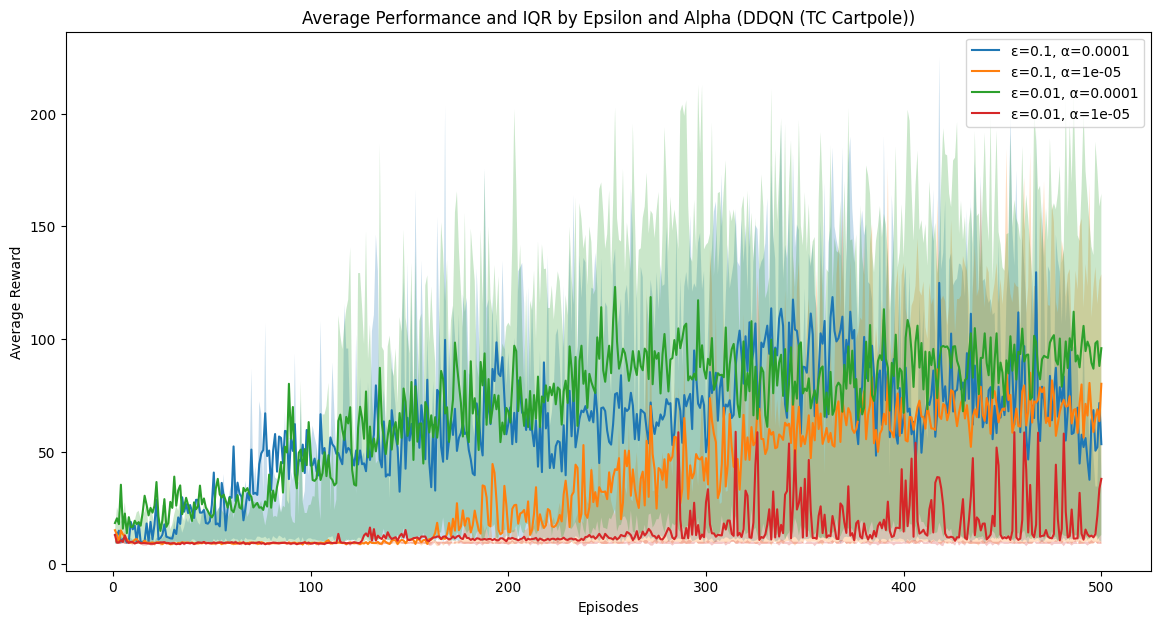

In [24]:
plot_rewards(rewards_data, algorithm_name="DDQN (TC Cartpole)")